In [3]:
import torch
import gzip
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from functions.sam_functions import batch_sample_from_class, multiclass_prob_batched
from functions.modified_predictor import modifiedPredictor

In [2]:
embeddings = torch.load(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/embeddings/embeddings.pt"
)

In [5]:
embeddings.shape

torch.Size([2978, 256, 64, 64])

In [3]:
ground_truth_path = (
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/preprocess/ground_truth.npy.gz"
)
with gzip.open(ground_truth_path, "rb") as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

## batched prompts

In [5]:
ground_truth = ground_truths[0]
ground_truth = torch.tensor(ground_truth)
points, labels = batch_sample_from_class(2, ground_truth, 1, 15, 5)

In [7]:
# plt.imshow(ground_truth)
# show_points(points, labels, ax=plt.gca())

In [4]:
labels

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])

In [5]:
points

tensor([[[110,  64],
         [115,  58],
         [ 90,  70],
         [116,  72],
         [ 91,  82],
         [ 92,  86],
         [120,  73],
         [ 82,  81],
         [ 94,  75],
         [ 94,  80],
         [114,  61],
         [110,  53],
         [ 89,  68],
         [101,  88],
         [ 93,  70],
         [105,  94],
         [125,  97],
         [110, 128],
         [112, 109],
         [111,  84]],

        [[ 99,  63],
         [103,  60],
         [ 83,  85],
         [ 87,  75],
         [ 89,  85],
         [ 84,  80],
         [105,  78],
         [ 93,  93],
         [ 94,  80],
         [ 95,  73],
         [108,  70],
         [ 79,  82],
         [101,  75],
         [ 88,  92],
         [ 81,  94],
         [135,  89],
         [118, 127],
         [118,  89],
         [118, 102],
         [135, 114]]])

In [4]:
logits_stack = torch.rand((2, 3, 4, 4))  # Replace with your actual tensor
result = multiclass_prob_batched(logits_stack, hard_labels=False)
sum_along_axis1 = torch.sum(result, dim=1)
# Check if the sum along axis=1 is close to 1 everywhere
is_sum_equal_to_1 = torch.allclose(sum_along_axis1, torch.ones_like(sum_along_axis1))
print(is_sum_equal_to_1)

True


## multiclass probs

In [4]:
mp = modifiedPredictor()
embedding = embeddings[0]
ground_truth = torch.tensor(ground_truths[0])

In [5]:
pr1 = batch_sample_from_class(2, ground_truth, 1, 10, 5)
pr2 = batch_sample_from_class(2, ground_truth, 2, 10, 5)
pr3 = batch_sample_from_class(2, ground_truth, 3, 10, 5)

In [6]:
logit_class_1 = mp.predict(embedding, pr1[0], pr1[1])
logit_class_2 = mp.predict(embedding, pr2[0], pr2[1])
logit_class_3 = mp.predict(embedding, pr3[0], pr3[1])
logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)

In [7]:
masks = multiclass_prob_batched(logit_stack)

In [8]:
mask = masks[0]

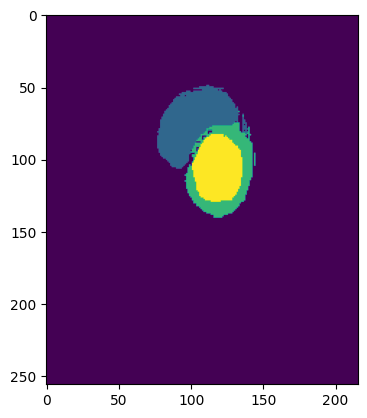

In [9]:
plt.imshow(mask.squeeze())

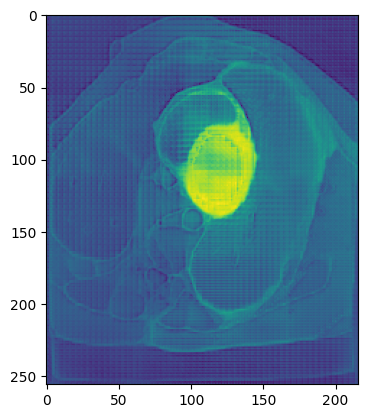

In [10]:
plt.imshow(logit_stack[0][1])

## built prompts based on error map

In [11]:
error_maps = masks != ground_truth
error_indices = torch.nonzero(error_maps == 1, as_tuple=False)
coordinates = error_indices[:, 2:]
coordinates

tensor([[ 49, 111],
        [ 49, 112],
        [ 50, 106],
        ...,
        [137, 127],
        [138, 114],
        [138, 125]])

In [52]:
def prompt_from_error_maps(
    error_maps, prompts, ground_truth, target_class, n_new_points=1
):
    batched_points = []
    batched_labels = []
    class_indices = torch.nonzero(ground_truth == target_class, as_tuple=False)
    error_indices = torch.nonzero(error_maps == 1, as_tuple=False)  # gives 4D array
    coordinates = error_indices[:, 2:]
    batch_indices = error_indices[:, 0]

    for batch in range(2):
        error_coordinates = coordinates[batch_indices == batch, :]
        indices = torch.tensor(
            np.intersect1d(
                class_indices.numpy(), error_coordinates.numpy(), assume_unique=True
            ),
            dtype=torch.long,
        )
        # Find the rows that are present in both tensors
        intersection_rows = torch.tensor(
            np.intersect1d(
                error_coordinates[:, 0] * 1000 + error_coordinates[:, 1],
                class_indices[:, 0] * 1000 + class_indices[:, 1],
                assume_unique=True,
            ),
            dtype=torch.long,
        )  # from ChatGPT

        # Extract the coordinates of the intersection ; from ChatGPT
        intersection_tensor = torch.stack(
            [(intersection_rows // 1000), (intersection_rows % 1000)], dim=-1
        )
        intersection_tensor[:, [0, 1]] = intersection_tensor[:, [1, 0]]  # swap axes

        # Remove coordinates that are already in prompts[batch][0]
        existing_coordinates = prompts[batch][0]
        mask = ~torch.any(
            torch.all(
                existing_coordinates[:, None, :] == intersection_tensor[None, :, :],
                dim=-1,
            ),
            dim=-1,
        )
        print(mask)
        print(intersection_tensor)
        filtered_intersection = intersection_tensor[mask]

        points = indices[
            np.random.choice(indices.shape[0], n_new_points, replace=False)
        ]
        print(points)
        labels = torch.tensor([1] * n_new_points)
        points = torch.concat((points, prompts[batch][0]))
        print(points)
        labels = torch.concat((labels, prompts[batch][1]))
        batched_points.append(points)
        batched_labels.append(labels)

    # Convert lists to tensors
    batched_points = torch.stack(batched_points)
    batched_labels = torch.stack(batched_labels)

    return batched_points, batched_labels

In [144]:
class Prompt:
    def __init__(self, target_class, ground_truth, coordinates, labels):
        self.batched_points = coordinates
        self.batched_labels = labels
        self.batch_size = coordinates.shape[0]
        self.ground_truth = ground_truth

        # transform sam formatted prompts back to image shaped tensors
        self.prompts_tensor_f, self.prompts_tensor_b = self.coordinates_to_masks(
            self.batched_points, self.batched_labels
        )
        # self.prompts_tensor_f contains all foreground points of the prompt
        # self.prompts_tensor_b contains all background points of the prompt

        self.masks = None
        self.error_maps = None

        self.target_class = target_class
        self.class_mask = self.ground_truth == self.target_class

    def coordinates_to_masks(self, coordinates, labels):
        prompts_tensor_f = torch.zeros(
            (
                coordinates.shape[0],
                1,
                self.ground_truth.shape[0],
                self.ground_truth.shape[1],
            ),
            dtype=torch.uint8,
        )
        # Get the indices where labels are equal to 1 (foreground)
        foreground_indices = torch.nonzero(labels == 1, as_tuple=False)
        foreground_coordinates = coordinates[
            foreground_indices[:, 0], foreground_indices[:, 1]
        ]
        # Reshape the result to retain the batch dimension
        foreground_coordinates = foreground_coordinates.view(
            coordinates.shape[0], -1, 2
        )
        # Set the specified points to 1 in the mask tensor
        for i in range(foreground_coordinates.shape[0]):
            row, col = foreground_coordinates[i, 0]
            prompts_tensor_f[i, 0, row, col] = 1

        # do everything again for background labeled points
        prompts_tensor_b = torch.zeros(
            (
                coordinates.shape[0],
                1,
                self.ground_truth.shape[0],
                self.ground_truth.shape[1],
            ),
            dtype=torch.uint8,
        )
        # Get the indices where labels are equal to 0 (background)
        background_indices = torch.nonzero(labels == 0, as_tuple=False)
        # check if there is background labeled points
        if background_indices.numel() != 0:
            background_coordinates = coordinates[
                background_indices[:, 0], background_indices[:, 1]
            ]
            # Reshape the result to retain the batch dimension
            background_coordinates = background_coordinates.view(
                coordinates.shape[0], -1, 2
            )

            # Set the specified points to 1 in the mask tensor
            for i in range(background_coordinates.shape[0]):
                row, col = background_coordinates[i, 0]
                prompts_tensor_b[i, 0, row, col] = 1

        return prompts_tensor_f, prompts_tensor_b

    def give_masks(self, masks):
        self.masks = masks
        self.error_maps = self.masks != self.ground_truth
        return None

    def get_prompts_sam(self):
        return self.batched_points, self.batched_labels

    def add_point_to_prompts(self):
        if self.error_maps == None:
            raise ValueError(
                "self.error_maps is None. Use .give_masks to give existing masks."
            )

        # combine class mask and error_maps
        masks_to_sample_from_f = torch.logical_and(self.error_maps, self.class_mask)
        # exclude already chosen points from the sampling
        masks_to_sample_from_f = torch.logical_and(
            ~self.prompts_tensor_f, masks_to_sample_from_f
        )
        contains_true = torch.any(torch.any(masks_to_sample_from_f, dim=2), dim=2)
        print(contains_true)
        # Split masks based on whether they contain false negatives or not
        for i in range(self.batch_size):
            # Sample points from masks with false negatives
            if contains_true[i]:
                # Get the mask for sampling foreground points for this batch entry
                mask_to_sample_from = masks_to_sample_from_f[i]
                # Sample a foreground point for this batch entry
                idx_f = (
                    mask_to_sample_from.view(-1)
                    .float()
                    .multinomial(num_samples=1, replacement=False)
                )
                # Update the prompts tensor for this batch entry
                self.prompts_tensor_f[i].view(-1)[idx_f] = 1

            # Sample false positives as background points for batch entries without false negatives
            else:
                # Get the mask for sampling background points for this batch entry
                mask_to_sample_from_b = torch.logical_and(
                    self.error_maps[i], torch.logical_not(self.class_mask[i])
                )
                mask_to_sample_from_b = torch.logical_and(
                    ~self.prompts_tensor_b[i], mask_to_sample_from_b
                )
                # Sample a background point for this batch entry
                idx_b = (
                    mask_to_sample_from_b.view(-1)
                    .float()
                    .multinomial(num_samples=1, replacement=False)
                )
                # Update the prompts tensor for this batch entry
                self.prompts_tensor_b[i].view(-1)[idx_b] = 1
        return self.prompts_tensor_f, self.prompts_tensor_b
        # TODO update the prompts in the SAM format
        # coordinates =
        # self.batched_points = coordinates
        # TODO add label depending on what type of point got sampled
        # labels =
        # self.batched_labels =

        # return None

## How to use the prompt class

In [109]:
ground_truth_path = (
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/preprocess/ground_truth.npy.gz"
)
with gzip.open(ground_truth_path, "rb") as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

embeddings = torch.load(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/embeddings/embeddings.pt"
)
ground_truth = torch.tensor(ground_truths[0])
embedding = embeddings[0]
# load already existing 1 point prompts from Thanh

# load already existing masks from Thanh

In [145]:
mp = modifiedPredictor()

In [146]:
batch_size = 10
pr1 = batch_sample_from_class(batch_size, ground_truth, 1, 1)
pr2 = batch_sample_from_class(batch_size, ground_truth, 2, 1)
pr3 = batch_sample_from_class(batch_size, ground_truth, 3, 1)
logit_class_1 = mp.predict(embedding, pr1[0], pr1[1])
logit_class_2 = mp.predict(embedding, pr2[0], pr2[1])
logit_class_3 = mp.predict(embedding, pr3[0], pr3[1])
logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)
masks = multiclass_prob_batched(logit_stack, hard_labels=True)

In [147]:
pr1[0].shape

torch.Size([10, 1, 2])

In [148]:
prompt1 = Prompt(1, ground_truth, pr1[0], pr1[1])
prompt1.give_masks(masks)
prompt_tensor_f, prompt_tensor_b = prompt1.add_point_to_prompts()

tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])


In [157]:
torch.nonzero(prompt_tensor_f)

tensor([[  0,   0, 106,  80],
        [  1,   0,  94, 100],
        [  1,   0, 108,  68],
        [  2,   0,  97,  67],
        [  3,   0, 100,  66],
        [  4,   0, 102,  85],
        [  4,   0, 113,  66],
        [  5,   0,  80, 108],
        [  5,   0, 101,  72],
        [  6,   0,  93,  95],
        [  6,   0,  98,  99],
        [  7,   0,  70, 131],
        [  7,   0,  90,  82],
        [  8,   0,  76, 126],
        [  8,   0, 122,  65],
        [  9,   0,  94, 100],
        [  9,   0, 117,  66]])

In [158]:
torch.nonzero(prompt_tensor_b)

tensor([[  0,   0,  96, 102],
        [  2,   0,  89, 103],
        [  3,   0, 136, 119]])

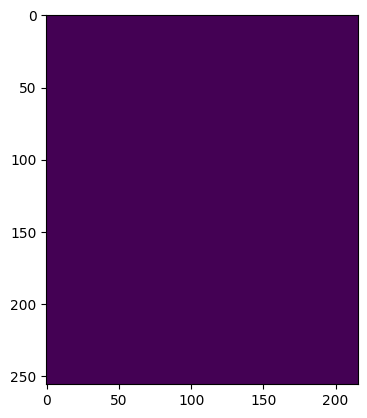

In [126]:
plt.imshow(prompt_tensor_b[2].squeeze())

In [ ]:
ground_truth = ground_truths[0]
embedding = embeddings[0]
iterations = 10
#load batched prompts and labels for 1st image for first class from prompts
#load masks for first image

prompt1 = Prompt(1, ground_truth, coordinates_1, labels_1)
prompt1.give_masks(masks)

#load batched prompts and labels for 1st image for second class from prompts
prompt2 = Prompt(2, ground_truth, coordinates_2, labels_2)
prompt2.give_masks(masks)

#load batched prompts and labels for 1st image for third class from prompts
prompt3 = Prompt(3, ground_truth, coordinates_3, labels_3)
prompt3.give_masks(masks)

for i in range(iterations):
    prompt1.add_point_to_prompts()
    batched_prompt_1 = prompt1.get_prompts_sam()
    prompt2.add_point_to_prompts()
    batched_prompt_2 = prompt1.get_prompts_sam()
    prompt3.add_point_to_prompts()
    batched_prompt_3 = prompt1.get_prompts_sam()
    #generate new masks with these prompts, do evaluation on the masks, save results
    
    prompt1.give_masks(masks)
    prompt2.give_masks(masks)
    prompt3.give_masks(masks)
    
    
